In [1]:
# 📦 Стандартные библиотеки
import os
import json
import time
import random
import glob
from pathlib import Path

# 📊 Обработка и визуализация данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 🤖 Машинное обучение (sklearn)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🔥 PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ⏳ Прогресс-бар
from tqdm import tqdm

In [2]:
# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

# ----------------------------
# Paths setup (UNIX style)
# ----------------------------

# 🔧 Вставь сюда свои актуальные пути:
# DATA_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input")
DATA_ROOT = Path("/kaggle/input")
# SAVE_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f")
SAVE_ROOT = Path("/kaggle/working/")
# CONFIG_PATH = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/cnn_2e-04lr_64bs_ELU_16f.json")
CONFIG_PATH = Path("/kaggle/input/cnn_2e-04lr_64bs_ELU_16f.json")
LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"

# ----------------------------
# Function to create a run-specific directory
# ----------------------------
def create_run_directory(
    run_name="cnn", lr=1e-3, batch_size=64, epochs=500,
    activation_fn=None, optimizer_name=None, base_dir=SAVE_ROOT
):
    run_id = f"{run_name}_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"
    
    run_dir = base_dir / run_id
    run_dir.mkdir(parents=True, exist_ok=True)

    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir


🛠 Device: cuda


In [3]:
# ➤ Класс CNN-модели
class WindPressureCNN(nn.Module):
    def __init__(self, input_channels, filters, activation_fn, use_batchnorm):
        super(WindPressureCNN, self).__init__()

        layers = []
        in_channels = input_channels
        for out_channels in filters:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Conv2d(filters[-1], filters[-2], kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(filters[-2], 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [4]:
# ➤ Пользовательский Dataset
class WindGridDataset(Dataset):
    def __init__(self, X_tensor, Y_tensor):
        self.X = X_tensor
        self.Y = Y_tensor

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ➤ Оценка
def evaluate_regression(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy().reshape(-1)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return {
        "MSE": mean_squared_error(y_true[mask], y_pred[mask]),
        "MAE": mean_absolute_error(y_true[mask], y_pred[mask]),
        "R2": r2_score(y_true[mask], y_pred[mask])
    }

In [5]:
# ➤ Основная функция
def train_cnn(
    lr,
    batch_size,
    epochs,
    input_channels,
    activation_fn,
    optimizer_name,
    loss_fn,
    filters,
    use_batchnorm,
    run_id,
    X_train, Y_train,
    X_val, Y_val,
    best_r2
    ):
    # ✅ Переводим данные в тензоры
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val,   dtype=torch.float32).to(device)
    Y_val   = torch.tensor(Y_val,   dtype=torch.float32).to(device)
    
    print("✅ Данные загружены в модель:")
    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    
    # 🎯 Основной график распределения
    plt.figure(figsize=(10, 5))
    plt.hist(Y_train.cpu().flatten(), bins=50, alpha=0.6, label='Train Y')  # <-- добавлено .cpu()
    plt.hist(Y_val.cpu().flatten(), bins=50, alpha=0.6, label='Val Y')      # <-- добавлено .cpu()
    plt.xlabel("Target Value")
    plt.ylabel("Frequency")
    plt.title(f"🎯 Target Distribution — Train vs Val")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    model = WindPressureCNN(
        input_channels=input_channels,
        filters=filters,
        activation_fn=activation_fn,
        use_batchnorm=use_batchnorm
    ).to(device)

    # Функция потерь
    criterion = loss_fn()

    # Оптимизатор
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Датасеты и загрузчики
    train_loader = DataLoader(WindGridDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(WindGridDataset(X_val, Y_val), batch_size=batch_size)

    # Тренировка
    best_loss = float("inf")
    patience = 150
    counter = 0

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Валидация каждые 100 эпох
        if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                y_val_pred = model(X_val)
                epoch_metrics = evaluate_regression(Y_val, y_val_pred)
                print(f"📉 Epoch {epoch + 1} | Train Loss: {epoch_loss:.6f} | "
                      f"Val R2: {epoch_metrics['R2']:.4f} | "
                      f"MAE: {epoch_metrics['MAE']:.4f} | "
                      f"MSE: {epoch_metrics['MSE']:.6f}")

        # Early Stopping
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                val_loss += loss.item()

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("⏹️ Early stopping")
                break

    # Оценка на валидации (финал)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        metrics = evaluate_regression(Y_val, y_pred)
        print(f"\n📈 Final Validation Metrics: {metrics}")

    if metrics["R2"] > best_r2:
        # Обновляем лучшую метрику
        best_r2 = metrics["R2"]
        
        # Удаляем все старые .pth в SAVE_ROOT
        for f in glob.glob(os.path.join(SAVE_ROOT, "*.pth")):
            os.remove(f)

        # Создаём красивое имя для сохранения весов
        filters_str = "-".join(map(str, filters))
        MODEL_FILENAME = (
        f"best_"
        f"{run_id}_"
        f"{activation_fn.__name__}_"
        f"{optimizer_name}.pth"
        )

        MODEL_SAVE_PATH = os.path.join(SAVE_ROOT, MODEL_FILENAME)

        # Сохраняем новые веса
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"💾 Сохранена новая лучшая модель: {MODEL_SAVE_PATH} (R² = {best_r2:.4f})")

    return model, metrics, best_r2
   



seeds: [90415, 799861, 120470, 296692, 851942, 655032, 835903, 233518, 882593, 42377]

🌱 Starting training with seed 90415
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


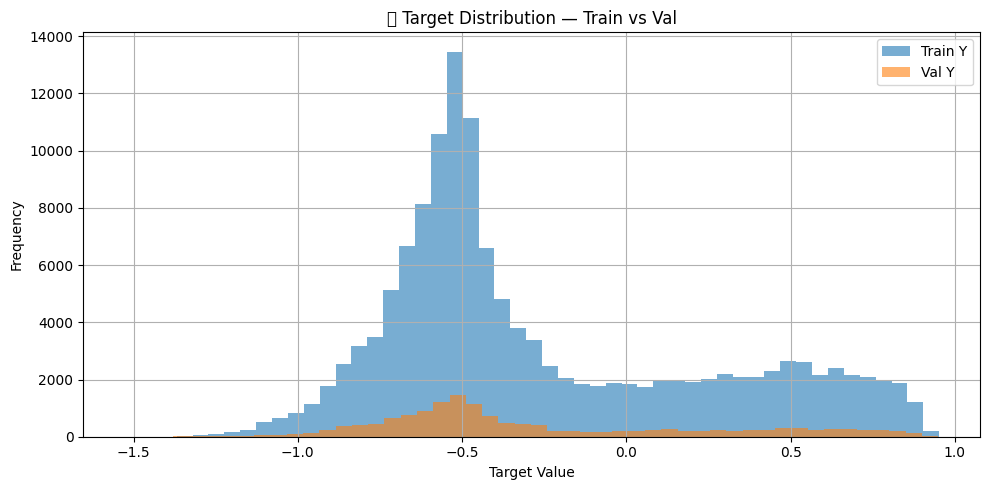

Epochs:   0%|          | 2/3000 [00:01<31:25,  1.59it/s]  

📉 Epoch 1 | Train Loss: 2.179302 | Val R2: -0.2493 | MAE: 0.5137 | MSE: 0.317764


Epochs:   3%|▎         | 101/3000 [00:18<08:23,  5.76it/s]

📉 Epoch 100 | Train Loss: 0.187588 | Val R2: 0.9412 | MAE: 0.0862 | MSE: 0.014952


Epochs:   7%|▋         | 201/3000 [00:36<08:26,  5.53it/s]

📉 Epoch 200 | Train Loss: 0.102361 | Val R2: 0.9568 | MAE: 0.0707 | MSE: 0.010993


Epochs:  10%|█         | 301/3000 [00:54<08:10,  5.51it/s]

📉 Epoch 300 | Train Loss: 0.090382 | Val R2: 0.9624 | MAE: 0.0636 | MSE: 0.009564


Epochs:  13%|█▎        | 401/3000 [01:12<07:56,  5.45it/s]

📉 Epoch 400 | Train Loss: 0.074192 | Val R2: 0.9736 | MAE: 0.0516 | MSE: 0.006716


Epochs:  17%|█▋        | 501/3000 [01:30<07:33,  5.51it/s]

📉 Epoch 500 | Train Loss: 0.060792 | Val R2: 0.9740 | MAE: 0.0517 | MSE: 0.006604


Epochs:  20%|██        | 601/3000 [01:48<07:15,  5.51it/s]

📉 Epoch 600 | Train Loss: 0.069362 | Val R2: 0.9659 | MAE: 0.0570 | MSE: 0.008679


Epochs:  23%|██▎       | 701/3000 [02:06<06:56,  5.52it/s]

📉 Epoch 700 | Train Loss: 0.056160 | Val R2: 0.9683 | MAE: 0.0595 | MSE: 0.008075


Epochs:  27%|██▋       | 801/3000 [02:25<06:39,  5.51it/s]

📉 Epoch 800 | Train Loss: 0.075957 | Val R2: 0.9663 | MAE: 0.0595 | MSE: 0.008578


Epochs:  27%|██▋       | 807/3000 [02:26<06:37,  5.51it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.007103042, 'MAE': 0.054773282, 'R2': 0.9720740898558285}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed90415_ELU_Adam.pth (R² = 0.9721)
✅ Done: input_seed90415
📊 Metrics: R²=0.9721 | MSE=0.007103 | MAE=0.054773

🌱 Starting training with seed 799861
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


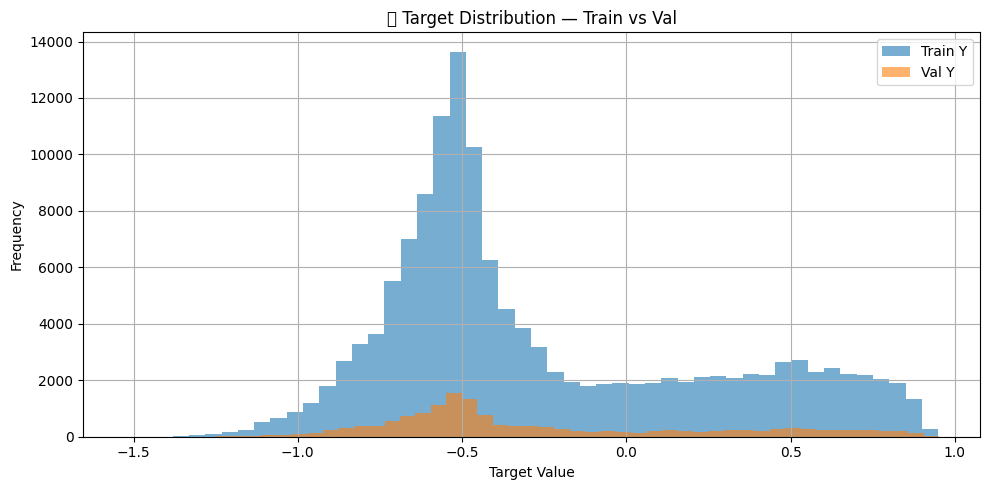

Epochs:   0%|          | 1/3000 [00:00<12:19,  4.06it/s]

📉 Epoch 1 | Train Loss: 2.011720 | Val R2: -0.1937 | MAE: 0.4972 | MSE: 0.296600


Epochs:   3%|▎         | 101/3000 [00:18<08:47,  5.50it/s]

📉 Epoch 100 | Train Loss: 0.161843 | Val R2: 0.9447 | MAE: 0.0848 | MSE: 0.013736


Epochs:   7%|▋         | 201/3000 [00:36<08:27,  5.52it/s]

📉 Epoch 200 | Train Loss: 0.092141 | Val R2: 0.9701 | MAE: 0.0583 | MSE: 0.007441


Epochs:  10%|█         | 301/3000 [00:54<08:18,  5.42it/s]

📉 Epoch 300 | Train Loss: 0.105393 | Val R2: 0.9691 | MAE: 0.0594 | MSE: 0.007672


Epochs:  13%|█▎        | 401/3000 [01:12<07:51,  5.52it/s]

📉 Epoch 400 | Train Loss: 0.110352 | Val R2: 0.9547 | MAE: 0.0731 | MSE: 0.011244


Epochs:  17%|█▋        | 501/3000 [01:31<07:34,  5.50it/s]

📉 Epoch 500 | Train Loss: 0.104310 | Val R2: 0.9488 | MAE: 0.0742 | MSE: 0.012728


Epochs:  20%|██        | 601/3000 [01:49<07:15,  5.51it/s]

📉 Epoch 600 | Train Loss: 0.098788 | Val R2: 0.9652 | MAE: 0.0653 | MSE: 0.008649


Epochs:  23%|██▎       | 701/3000 [02:07<06:57,  5.51it/s]

📉 Epoch 700 | Train Loss: 0.050555 | Val R2: 0.9737 | MAE: 0.0506 | MSE: 0.006541


Epochs:  27%|██▋       | 801/3000 [02:25<06:38,  5.52it/s]

📉 Epoch 800 | Train Loss: 0.095828 | Val R2: 0.9684 | MAE: 0.0566 | MSE: 0.007841


Epochs:  30%|███       | 901/3000 [02:43<06:19,  5.52it/s]

📉 Epoch 900 | Train Loss: 0.084524 | Val R2: 0.9705 | MAE: 0.0561 | MSE: 0.007333


Epochs:  33%|███▎      | 1001/3000 [03:02<06:04,  5.49it/s]

📉 Epoch 1000 | Train Loss: 0.058239 | Val R2: 0.9758 | MAE: 0.0503 | MSE: 0.006013


Epochs:  35%|███▌      | 1061/3000 [03:13<05:52,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0064587016, 'MAE': 0.0506019, 'R2': 0.9740071471347437}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed799861_ELU_Adam.pth (R² = 0.9740)
✅ Done: input_seed799861
📊 Metrics: R²=0.9740 | MSE=0.006459 | MAE=0.050602

🌱 Starting training with seed 120470
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


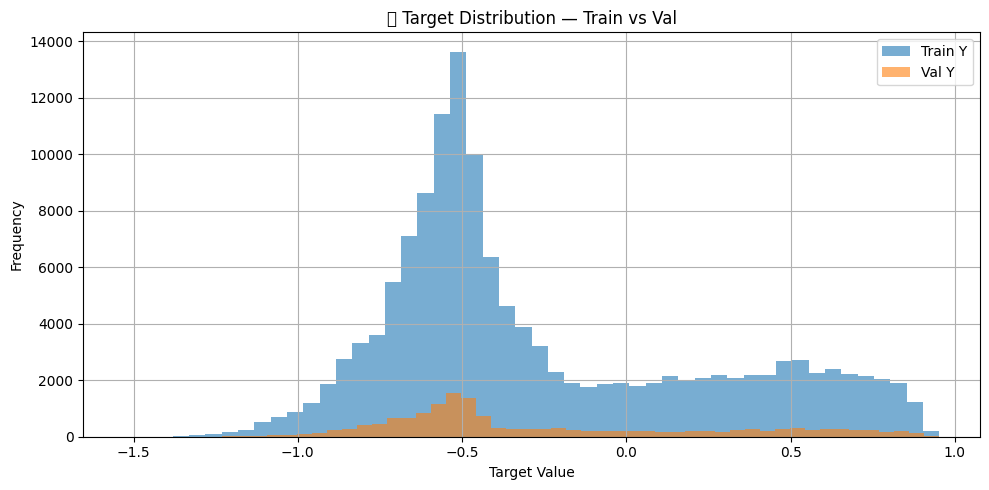

Epochs:   0%|          | 2/3000 [00:00<09:11,  5.44it/s]

📉 Epoch 1 | Train Loss: 1.978058 | Val R2: -0.0840 | MAE: 0.4686 | MSE: 0.272457


Epochs:   3%|▎         | 101/3000 [00:18<08:46,  5.51it/s]

📉 Epoch 100 | Train Loss: 0.181497 | Val R2: 0.9472 | MAE: 0.0841 | MSE: 0.013264


Epochs:   7%|▋         | 201/3000 [00:36<08:34,  5.44it/s]

📉 Epoch 200 | Train Loss: 0.138358 | Val R2: 0.9463 | MAE: 0.0806 | MSE: 0.013500


Epochs:  10%|█         | 301/3000 [00:54<08:09,  5.51it/s]

📉 Epoch 300 | Train Loss: 0.100897 | Val R2: 0.9630 | MAE: 0.0637 | MSE: 0.009292


Epochs:  13%|█▎        | 401/3000 [01:12<07:51,  5.51it/s]

📉 Epoch 400 | Train Loss: 0.106925 | Val R2: 0.9272 | MAE: 0.0853 | MSE: 0.018302


Epochs:  17%|█▋        | 501/3000 [01:31<07:33,  5.51it/s]

📉 Epoch 500 | Train Loss: 0.083088 | Val R2: 0.9744 | MAE: 0.0530 | MSE: 0.006429


Epochs:  20%|██        | 601/3000 [01:49<07:14,  5.52it/s]

📉 Epoch 600 | Train Loss: 0.085984 | Val R2: 0.9740 | MAE: 0.0546 | MSE: 0.006528


Epochs:  23%|██▎       | 701/3000 [02:07<06:57,  5.51it/s]

📉 Epoch 700 | Train Loss: 0.076173 | Val R2: 0.9715 | MAE: 0.0565 | MSE: 0.007166


Epochs:  27%|██▋       | 801/3000 [02:25<06:38,  5.51it/s]

📉 Epoch 800 | Train Loss: 0.061966 | Val R2: 0.9714 | MAE: 0.0543 | MSE: 0.007193


Epochs:  29%|██▉       | 873/3000 [02:38<06:27,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0067908084, 'MAE': 0.055205487, 'R2': 0.9729813016387838}
✅ Done: input_seed120470
📊 Metrics: R²=0.9730 | MSE=0.006791 | MAE=0.055205

🌱 Starting training with seed 296692
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


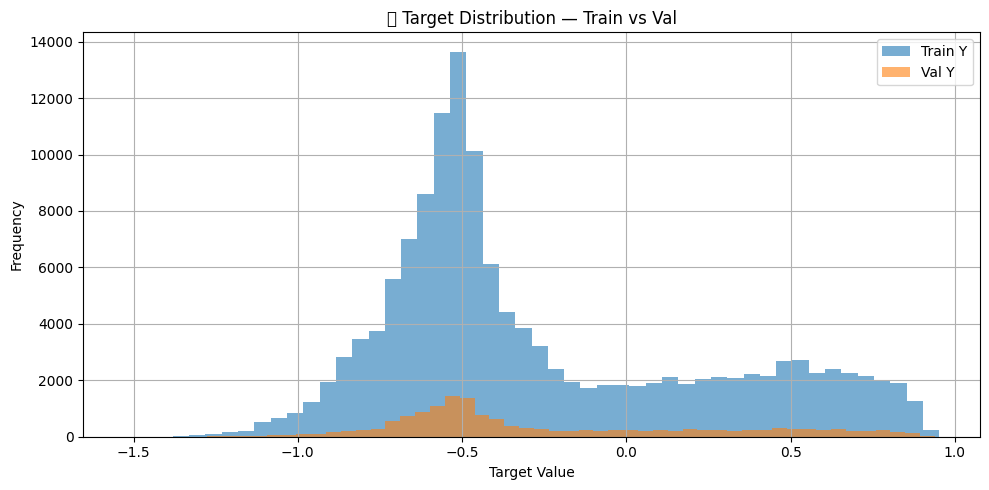

Epochs:   0%|          | 2/3000 [00:00<09:49,  5.08it/s]

📉 Epoch 1 | Train Loss: 2.087846 | Val R2: -0.1997 | MAE: 0.4882 | MSE: 0.288946


Epochs:   3%|▎         | 101/3000 [00:18<08:46,  5.51it/s]

📉 Epoch 100 | Train Loss: 0.246742 | Val R2: 0.9195 | MAE: 0.1028 | MSE: 0.019398


Epochs:   7%|▋         | 201/3000 [00:36<08:27,  5.51it/s]

📉 Epoch 200 | Train Loss: 0.140014 | Val R2: 0.9587 | MAE: 0.0705 | MSE: 0.009938


Epochs:  10%|█         | 301/3000 [00:54<08:09,  5.51it/s]

📉 Epoch 300 | Train Loss: 0.086326 | Val R2: 0.9688 | MAE: 0.0600 | MSE: 0.007508


Epochs:  13%|█▎        | 401/3000 [01:12<07:51,  5.52it/s]

📉 Epoch 400 | Train Loss: 0.091515 | Val R2: 0.9625 | MAE: 0.0629 | MSE: 0.009040


Epochs:  17%|█▋        | 501/3000 [01:31<07:32,  5.52it/s]

📉 Epoch 500 | Train Loss: 0.078899 | Val R2: 0.9730 | MAE: 0.0548 | MSE: 0.006493


Epochs:  20%|██        | 601/3000 [01:49<07:15,  5.50it/s]

📉 Epoch 600 | Train Loss: 0.068264 | Val R2: 0.9718 | MAE: 0.0538 | MSE: 0.006798


Epochs:  23%|██▎       | 701/3000 [02:07<06:57,  5.51it/s]

📉 Epoch 700 | Train Loss: 0.068328 | Val R2: 0.9770 | MAE: 0.0500 | MSE: 0.005550


Epochs:  27%|██▋       | 801/3000 [02:25<06:40,  5.49it/s]

📉 Epoch 800 | Train Loss: 0.045440 | Val R2: 0.9804 | MAE: 0.0430 | MSE: 0.004716


Epochs:  30%|███       | 901/3000 [02:43<06:20,  5.51it/s]

📉 Epoch 900 | Train Loss: 0.072469 | Val R2: 0.9780 | MAE: 0.0476 | MSE: 0.005309


Epochs:  33%|███▎      | 1001/3000 [03:01<06:02,  5.51it/s]

📉 Epoch 1000 | Train Loss: 0.043507 | Val R2: 0.9787 | MAE: 0.0449 | MSE: 0.005142


Epochs:  34%|███▍      | 1018/3000 [03:05<06:00,  5.50it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.005607364, 'MAE': 0.04811582, 'R2': 0.9767178879254683}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed296692_ELU_Adam.pth (R² = 0.9767)
✅ Done: input_seed296692
📊 Metrics: R²=0.9767 | MSE=0.005607 | MAE=0.048116

🌱 Starting training with seed 851942
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


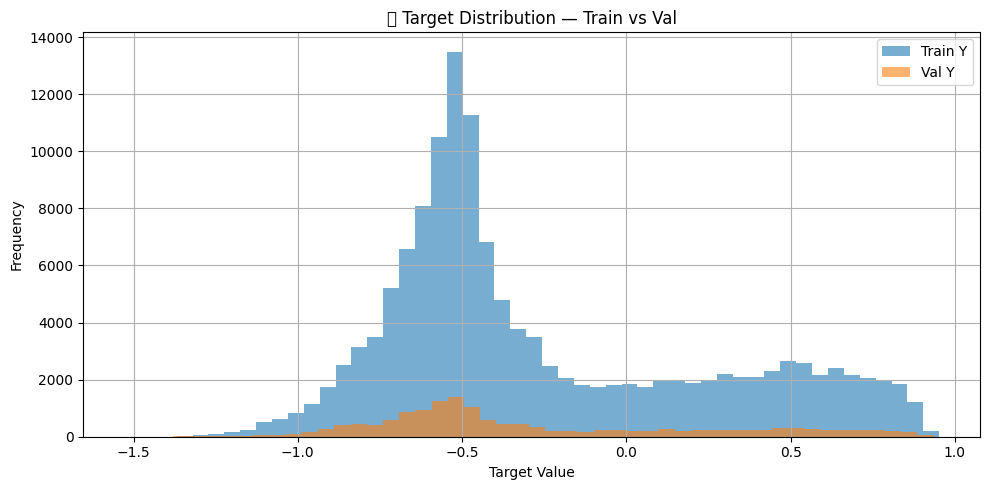

Epochs:   0%|          | 2/3000 [00:00<09:11,  5.43it/s]

📉 Epoch 1 | Train Loss: 1.866954 | Val R2: -0.0871 | MAE: 0.4735 | MSE: 0.281149


Epochs:   3%|▎         | 101/3000 [00:18<08:46,  5.51it/s]

📉 Epoch 100 | Train Loss: 0.175650 | Val R2: 0.9523 | MAE: 0.0751 | MSE: 0.012326


Epochs:   7%|▋         | 201/3000 [00:36<08:27,  5.51it/s]

📉 Epoch 200 | Train Loss: 0.099227 | Val R2: 0.9603 | MAE: 0.0675 | MSE: 0.010255


Epochs:  10%|█         | 301/3000 [00:54<08:09,  5.51it/s]

📉 Epoch 300 | Train Loss: 0.100903 | Val R2: 0.9652 | MAE: 0.0621 | MSE: 0.008987


Epochs:  13%|█▎        | 401/3000 [01:12<07:50,  5.52it/s]

📉 Epoch 400 | Train Loss: 0.072507 | Val R2: 0.9709 | MAE: 0.0573 | MSE: 0.007527


Epochs:  17%|█▋        | 501/3000 [01:31<07:33,  5.52it/s]

📉 Epoch 500 | Train Loss: 0.096205 | Val R2: 0.9621 | MAE: 0.0683 | MSE: 0.009813


Epochs:  18%|█▊        | 527/3000 [01:35<07:30,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0088546155, 'MAE': 0.06295506, 'R2': 0.9657614031753387}
✅ Done: input_seed851942
📊 Metrics: R²=0.9658 | MSE=0.008855 | MAE=0.062955

🌱 Starting training with seed 655032
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


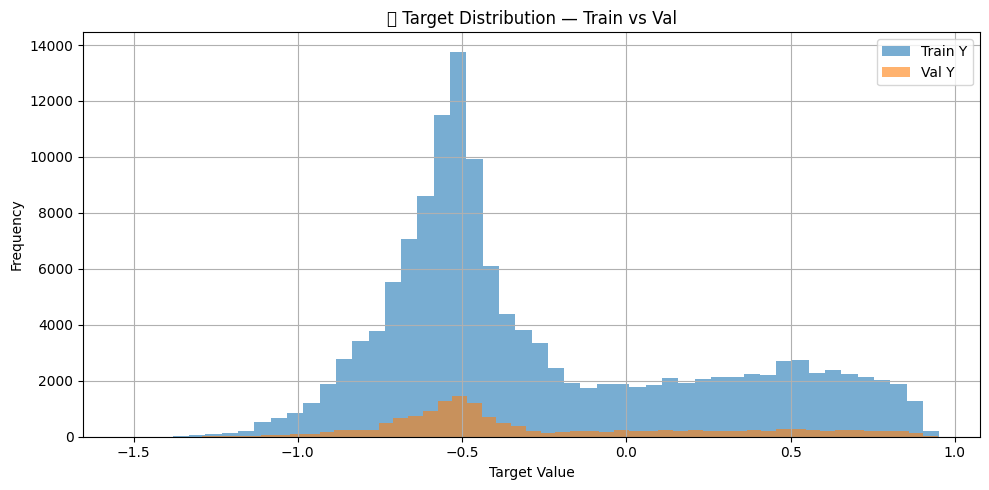

Epochs:   0%|          | 2/3000 [00:00<10:15,  4.87it/s]

📉 Epoch 1 | Train Loss: 1.870625 | Val R2: -0.1595 | MAE: 0.4879 | MSE: 0.288050


Epochs:   3%|▎         | 101/3000 [00:18<08:46,  5.50it/s]

📉 Epoch 100 | Train Loss: 0.112334 | Val R2: 0.9531 | MAE: 0.0745 | MSE: 0.011658


Epochs:   7%|▋         | 201/3000 [00:36<08:27,  5.52it/s]

📉 Epoch 200 | Train Loss: 0.107925 | Val R2: 0.9663 | MAE: 0.0613 | MSE: 0.008368


Epochs:  10%|█         | 301/3000 [00:54<08:10,  5.51it/s]

📉 Epoch 300 | Train Loss: 0.072295 | Val R2: 0.9694 | MAE: 0.0547 | MSE: 0.007602


Epochs:  13%|█▎        | 401/3000 [01:12<07:51,  5.51it/s]

📉 Epoch 400 | Train Loss: 0.084467 | Val R2: 0.9679 | MAE: 0.0556 | MSE: 0.007970


Epochs:  17%|█▋        | 501/3000 [01:31<07:34,  5.49it/s]

📉 Epoch 500 | Train Loss: 0.062346 | Val R2: 0.9717 | MAE: 0.0536 | MSE: 0.007041


Epochs:  20%|██        | 601/3000 [01:49<07:15,  5.51it/s]

📉 Epoch 600 | Train Loss: 0.101272 | Val R2: 0.9531 | MAE: 0.0671 | MSE: 0.011643


Epochs:  23%|██▎       | 701/3000 [02:07<06:56,  5.52it/s]

📉 Epoch 700 | Train Loss: 0.058791 | Val R2: 0.9702 | MAE: 0.0593 | MSE: 0.007402


Epochs:  26%|██▌       | 780/3000 [02:22<06:44,  5.49it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0077020153, 'MAE': 0.05669055, 'R2': 0.968997732121087}
✅ Done: input_seed655032
📊 Metrics: R²=0.9690 | MSE=0.007702 | MAE=0.056691

🌱 Starting training with seed 835903
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


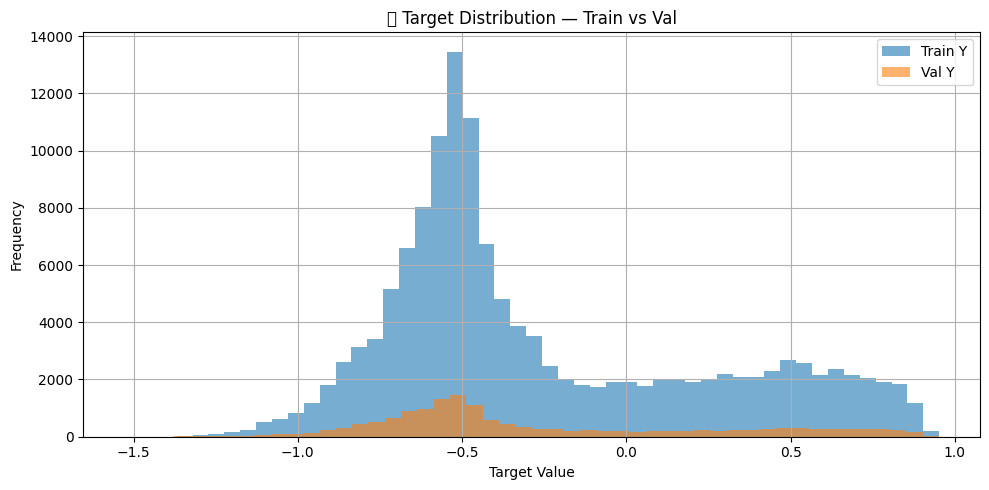

Epochs:   0%|          | 2/3000 [00:00<09:03,  5.52it/s]

📉 Epoch 1 | Train Loss: 1.900728 | Val R2: -0.4359 | MAE: 0.5604 | MSE: 0.374412


Epochs:   3%|▎         | 101/3000 [00:18<08:47,  5.50it/s]

📉 Epoch 100 | Train Loss: 0.163568 | Val R2: 0.9329 | MAE: 0.0890 | MSE: 0.017494


Epochs:   7%|▋         | 201/3000 [00:36<08:28,  5.50it/s]

📉 Epoch 200 | Train Loss: 0.120689 | Val R2: 0.9510 | MAE: 0.0746 | MSE: 0.012789


Epochs:  10%|█         | 301/3000 [00:54<08:10,  5.50it/s]

📉 Epoch 300 | Train Loss: 0.073416 | Val R2: 0.9663 | MAE: 0.0628 | MSE: 0.008786


Epochs:  13%|█▎        | 401/3000 [01:12<07:51,  5.51it/s]

📉 Epoch 400 | Train Loss: 0.069691 | Val R2: 0.9734 | MAE: 0.0544 | MSE: 0.006946


Epochs:  17%|█▋        | 501/3000 [01:31<07:34,  5.50it/s]

📉 Epoch 500 | Train Loss: 0.075706 | Val R2: 0.9722 | MAE: 0.0561 | MSE: 0.007261


Epochs:  20%|██        | 601/3000 [01:49<07:14,  5.52it/s]

📉 Epoch 600 | Train Loss: 0.059121 | Val R2: 0.9741 | MAE: 0.0524 | MSE: 0.006753


Epochs:  23%|██▎       | 701/3000 [02:07<06:57,  5.51it/s]

📉 Epoch 700 | Train Loss: 0.091528 | Val R2: 0.9639 | MAE: 0.0643 | MSE: 0.009406


Epochs:  27%|██▋       | 799/3000 [02:25<06:40,  5.49it/s]


📉 Epoch 800 | Train Loss: 0.045566 | Val R2: 0.9779 | MAE: 0.0478 | MSE: 0.005766
⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0057661985, 'MAE': 0.047764976, 'R2': 0.9778857141610078}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed835903_ELU_Adam.pth (R² = 0.9779)
✅ Done: input_seed835903
📊 Metrics: R²=0.9779 | MSE=0.005766 | MAE=0.047765

🌱 Starting training with seed 233518
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


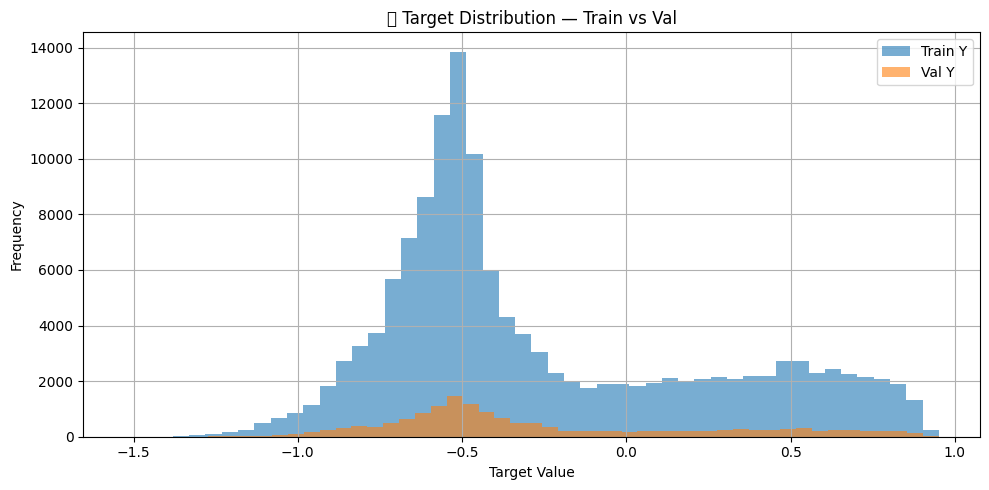

Epochs:   0%|          | 2/3000 [00:00<10:23,  4.81it/s]

📉 Epoch 1 | Train Loss: 1.882199 | Val R2: -0.1910 | MAE: 0.4829 | MSE: 0.283341


Epochs:   3%|▎         | 101/3000 [00:18<08:46,  5.50it/s]

📉 Epoch 100 | Train Loss: 0.141263 | Val R2: 0.9391 | MAE: 0.0878 | MSE: 0.014486


Epochs:   7%|▋         | 201/3000 [00:36<08:27,  5.52it/s]

📉 Epoch 200 | Train Loss: 0.145513 | Val R2: 0.9590 | MAE: 0.0676 | MSE: 0.009753


Epochs:  10%|█         | 301/3000 [00:54<08:09,  5.51it/s]

📉 Epoch 300 | Train Loss: 0.155915 | Val R2: 0.9386 | MAE: 0.0803 | MSE: 0.014603


Epochs:  13%|█▎        | 401/3000 [01:12<07:52,  5.50it/s]

📉 Epoch 400 | Train Loss: 0.093916 | Val R2: 0.9629 | MAE: 0.0638 | MSE: 0.008833


Epochs:  17%|█▋        | 501/3000 [01:31<07:33,  5.51it/s]

📉 Epoch 500 | Train Loss: 0.098179 | Val R2: 0.9657 | MAE: 0.0609 | MSE: 0.008156


Epochs:  20%|██        | 601/3000 [01:49<07:15,  5.51it/s]

📉 Epoch 600 | Train Loss: 0.056379 | Val R2: 0.9668 | MAE: 0.0577 | MSE: 0.007889


Epochs:  23%|██▎       | 701/3000 [02:07<06:57,  5.51it/s]

📉 Epoch 700 | Train Loss: 0.048216 | Val R2: 0.9719 | MAE: 0.0521 | MSE: 0.006696


Epochs:  27%|██▋       | 801/3000 [02:25<06:39,  5.51it/s]

📉 Epoch 800 | Train Loss: 0.052606 | Val R2: 0.9698 | MAE: 0.0574 | MSE: 0.007190


Epochs:  30%|███       | 901/3000 [02:43<06:21,  5.50it/s]

📉 Epoch 900 | Train Loss: 0.062457 | Val R2: 0.9723 | MAE: 0.0519 | MSE: 0.006593


Epochs:  33%|███▎      | 1001/3000 [03:01<06:02,  5.51it/s]

📉 Epoch 1000 | Train Loss: 0.033515 | Val R2: 0.9765 | MAE: 0.0472 | MSE: 0.005588


Epochs:  37%|███▋      | 1101/3000 [03:20<05:45,  5.50it/s]

📉 Epoch 1100 | Train Loss: 0.042160 | Val R2: 0.9687 | MAE: 0.0554 | MSE: 0.007444


Epochs:  40%|████      | 1201/3000 [03:38<05:26,  5.51it/s]

📉 Epoch 1200 | Train Loss: 0.034389 | Val R2: 0.9727 | MAE: 0.0501 | MSE: 0.006497


Epochs:  42%|████▏     | 1262/3000 [03:49<05:16,  5.50it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0076252404, 'MAE': 0.05729273, 'R2': 0.9679480061424864}
✅ Done: input_seed233518
📊 Metrics: R²=0.9679 | MSE=0.007625 | MAE=0.057293

🌱 Starting training with seed 882593
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


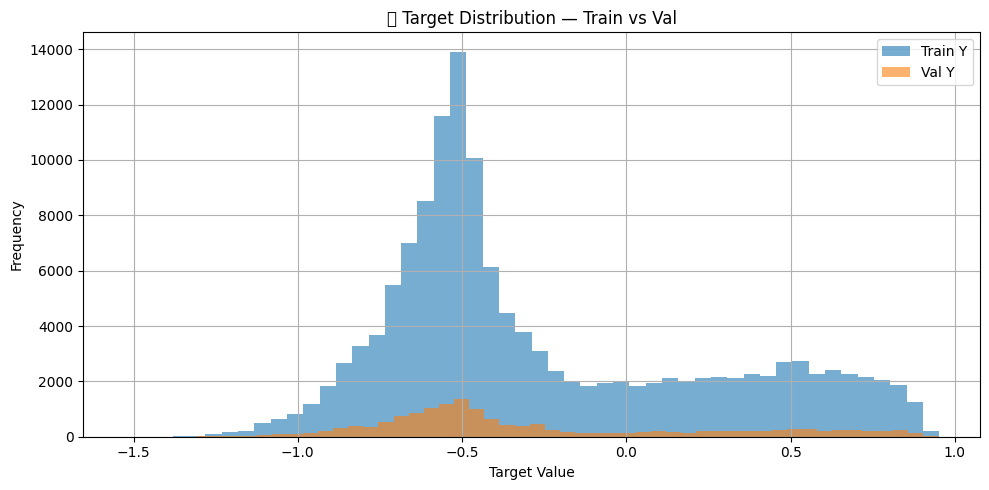

Epochs:   0%|          | 2/3000 [00:00<08:52,  5.64it/s]

📉 Epoch 1 | Train Loss: 1.854104 | Val R2: -0.4128 | MAE: 0.5531 | MSE: 0.361621


Epochs:   3%|▎         | 101/3000 [00:18<08:45,  5.51it/s]

📉 Epoch 100 | Train Loss: 0.180758 | Val R2: 0.9410 | MAE: 0.0851 | MSE: 0.015110


Epochs:   7%|▋         | 201/3000 [00:36<08:29,  5.50it/s]

📉 Epoch 200 | Train Loss: 0.106494 | Val R2: 0.9594 | MAE: 0.0708 | MSE: 0.010380


Epochs:  10%|█         | 301/3000 [00:54<08:09,  5.51it/s]

📉 Epoch 300 | Train Loss: 0.111258 | Val R2: 0.9584 | MAE: 0.0708 | MSE: 0.010639


Epochs:  13%|█▎        | 401/3000 [01:12<07:53,  5.48it/s]

📉 Epoch 400 | Train Loss: 0.097221 | Val R2: 0.9676 | MAE: 0.0621 | MSE: 0.008287


Epochs:  17%|█▋        | 501/3000 [01:31<07:34,  5.50it/s]

📉 Epoch 500 | Train Loss: 0.065134 | Val R2: 0.9749 | MAE: 0.0539 | MSE: 0.006429


Epochs:  20%|██        | 601/3000 [01:49<07:16,  5.50it/s]

📉 Epoch 600 | Train Loss: 0.066659 | Val R2: 0.9686 | MAE: 0.0588 | MSE: 0.008040


Epochs:  23%|██▎       | 701/3000 [02:07<06:57,  5.51it/s]

📉 Epoch 700 | Train Loss: 0.074140 | Val R2: 0.9638 | MAE: 0.0623 | MSE: 0.009261


Epochs:  27%|██▋       | 801/3000 [02:25<06:38,  5.52it/s]

📉 Epoch 800 | Train Loss: 0.099647 | Val R2: 0.9614 | MAE: 0.0641 | MSE: 0.009870


Epochs:  30%|███       | 901/3000 [02:43<06:20,  5.52it/s]

📉 Epoch 900 | Train Loss: 0.068645 | Val R2: 0.9801 | MAE: 0.0459 | MSE: 0.005098


Epochs:  30%|███       | 910/3000 [02:45<06:20,  5.50it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0054498087, 'MAE': 0.047962233, 'R2': 0.9787088342101532}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed882593_ELU_Adam.pth (R² = 0.9787)
✅ Done: input_seed882593
📊 Metrics: R²=0.9787 | MSE=0.005450 | MAE=0.047962

🌱 Starting training with seed 42377
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_35/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


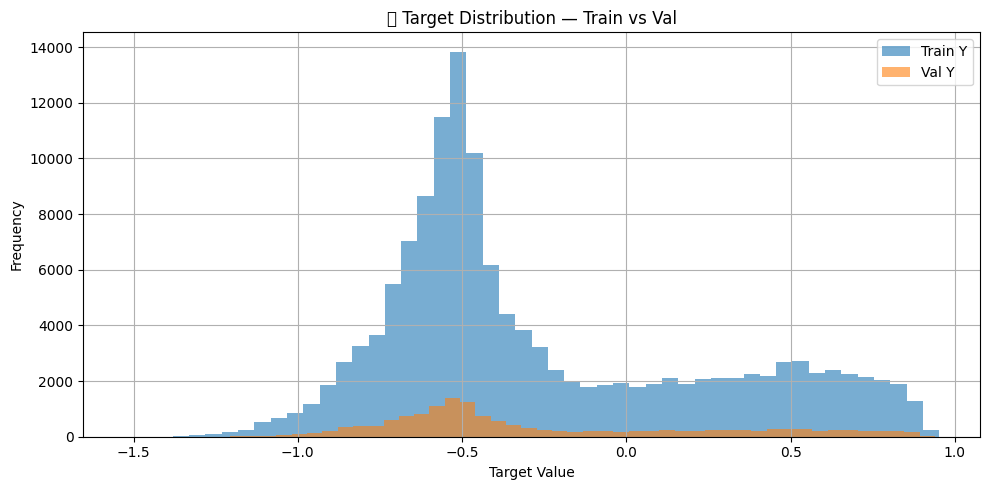

Epochs:   0%|          | 2/3000 [00:00<10:27,  4.77it/s]

📉 Epoch 1 | Train Loss: 1.872911 | Val R2: -0.3289 | MAE: 0.5259 | MSE: 0.331494


Epochs:   3%|▎         | 101/3000 [00:18<08:45,  5.52it/s]

📉 Epoch 100 | Train Loss: 0.147753 | Val R2: 0.9548 | MAE: 0.0737 | MSE: 0.011274


Epochs:   7%|▋         | 201/3000 [00:36<08:27,  5.51it/s]

📉 Epoch 200 | Train Loss: 0.140332 | Val R2: 0.9440 | MAE: 0.0836 | MSE: 0.013969


Epochs:  10%|█         | 301/3000 [00:54<08:09,  5.51it/s]

📉 Epoch 300 | Train Loss: 0.089701 | Val R2: 0.9603 | MAE: 0.0640 | MSE: 0.009892


Epochs:  13%|█▎        | 401/3000 [01:12<07:52,  5.50it/s]

📉 Epoch 400 | Train Loss: 0.084591 | Val R2: 0.9676 | MAE: 0.0610 | MSE: 0.008075


Epochs:  17%|█▋        | 501/3000 [01:31<07:34,  5.49it/s]

📉 Epoch 500 | Train Loss: 0.063405 | Val R2: 0.9709 | MAE: 0.0537 | MSE: 0.007259


Epochs:  20%|██        | 601/3000 [01:49<07:15,  5.51it/s]

📉 Epoch 600 | Train Loss: 0.072070 | Val R2: 0.9676 | MAE: 0.0582 | MSE: 0.008077


Epochs:  21%|██        | 623/3000 [01:53<07:12,  5.49it/s]

⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.006452475, 'MAE': 0.051115222, 'R2': 0.9741337277690674}
✅ Done: input_seed42377
📊 Metrics: R²=0.9741 | MSE=0.006452 | MAE=0.051115

🏆 Лучший запуск:
🆔 Run ID: input_seed882593
📈 R²: 0.9787
📉 MAE: 0.0480
📉 MSE: 0.005450


In [6]:
all_results = []

# === Установка сидов
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# === Загрузка данных и конфига
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)


X_all = np.load(DATA_ROOT / "X_cnn.npy")
Y_all = np.load(DATA_ROOT / "Y_cnn.npy")

# === Цикл по сидом
NUM_RUNS = 10
random.seed(int(time.time()))  # или просто random.seed() для более случайной генерации
seeds = random.sample(range(1_000_000), NUM_RUNS)  # 10 уникальных случайных seed
base_run_id = CONFIG_PATH.parent.name
print('seeds:', seeds)

best_r2 = -np.inf

for seed in seeds:
    print(f"\n🌱 Starting training with seed {seed}")
    set_seed(seed)

    # 💡 Разбиение train/val с текущим сидом
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_all, Y_all, test_size=0.1, random_state=seed
    )

    # 🔁 Создание новой копии конфига
    config_run = config.copy()
    run_id = f"{base_run_id}_seed{seed}"
    config_run["seed"] = seed
    config_run["run_id"] = run_id

    model, metrics, best_r2 = train_cnn(
        lr=config_run["lr"],
        batch_size=config_run["batch_size"],
        epochs=config_run["epochs"],
        input_channels=config_run["input_channels"],
        activation_fn=getattr(torch.nn, config_run["activation_fn"]),
        optimizer_name=config_run["optimizer"],
        loss_fn=getattr(torch.nn, config_run["loss_fn"]),
        filters=config_run["filters"],
        use_batchnorm=config_run["batchnorm"],
        run_id=run_id,
        X_train=X_train,
        Y_train=Y_train,
        X_val=X_val,
        Y_val=Y_val,
        best_r2 = best_r2
    )

    all_results.append({
        "run_id": run_id,
        "seed": seed,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    print(f"✅ Done: {run_id}")
    print(f"📊 Metrics: R²={metrics['R2']:.4f} | MSE={metrics['MSE']:.6f} | MAE={metrics['MAE']:.6f}")

    # === Логирование в CSV
    log_header = "run_id,seed,lr,batch_size,activation_fn,optimizer,filters,R2,MAE,MSE\n"

    log_line = (
        f"{run_id},{seed},{config_run['lr']:.0e},{config_run['batch_size']},"
        f"{config_run['activation_fn']},{config_run['optimizer']},"
        f"\"{config_run['filters']}\",{metrics['R2']:.4f},{metrics['MAE']:.4f},{metrics['MSE']:.6f}\n"
    )

    # Создаём файл, если его ещё нет
    write_header = not os.path.exists(LOG_CSV_PATH)

    with open(LOG_CSV_PATH, "a") as f:
        if write_header:
            f.write(log_header)
        f.write(log_line)

# Найдём лучший результат
best_result = max(all_results, key=lambda x: x["R2"])

# Выводим
print("\n🏆 Лучший запуск:")
print(f"🆔 Run ID: {best_result['run_id']}")
print(f"📈 R²: {best_result['R2']:.4f}")
print(f"📉 MAE: {best_result['MAE']:.4f}")
print(f"📉 MSE: {best_result['MSE']:.6f}")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_35/2889097417.py:56: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/2889097417.py:56: UserWarning: Glyph 127919 (\N{DIRE

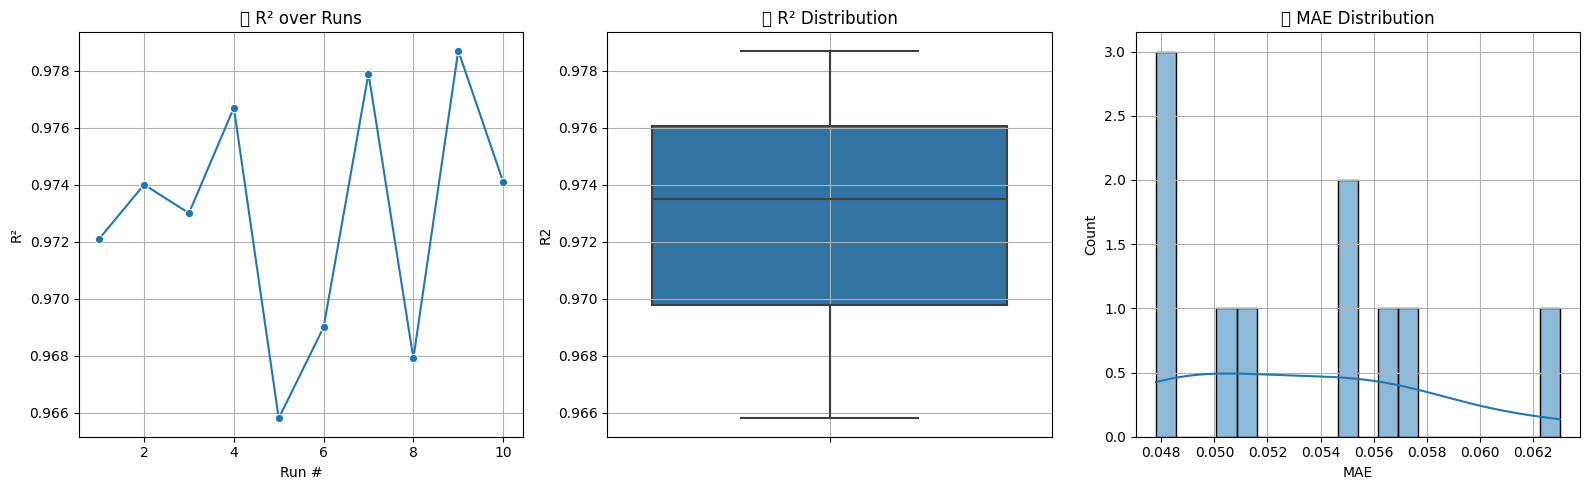

✅ Stability analysis complete:
{
    "R2_mean": 0.9729,
    "R2_std": 0.0043,
    "MAE_mean": 0.0533,
    "MAE_std": 0.005,
    "MSE_mean": 0.006781,
    "MSE_std": 0.001073,
    "runs": 10
}
📁 Saved metrics: /kaggle/working/stability_working.json
🖼️  Saved plot: /kaggle/working/stability_plot_working.png


In [7]:
# 📁 src/tuning/analyze_stability.py

# 📌 Пути (адаптируй под свой путь к лог-файлу)

LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"
ARCH_LABEL = SAVE_ROOT.name  # используем имя папки как ярлык модели

# 📥 Загрузка результатов
df = pd.read_csv(LOG_CSV_PATH)

# ➕ Добавим колонку run по индексу
df["run"] = range(1, len(df) + 1)

# 📊 Подсчёт статистик стабильности
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Сохраняем метрики
stability_path = SAVE_ROOT / f"stability_{ARCH_LABEL}.json"
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Визуализация
plt.figure(figsize=(16, 5))

# ➤ R² по прогонам
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("📈 R² over Runs")
plt.xlabel("Run #")
plt.ylabel("R²")
plt.grid(True)

# ➤ Boxplot R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("🎯 R² Distribution")
plt.grid(True)

# ➤ Гистограмма MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("📉 MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Сохраняем график
fig_path = SAVE_ROOT / f"stability_plot_{ARCH_LABEL}.png"
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Вывод
print("✅ Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")
